In [1]:
from math import sin,cos,pi,log,exp
import matplotlib.pyplot as plt
import numpy as np
import cfeplib

In [2]:
f=open('oxtrajtraj-6-0.rmsd')
lrmsd=[]
for l in f:
    l=l.split()
    lrmsd.append(float(l[1]))
f.close()

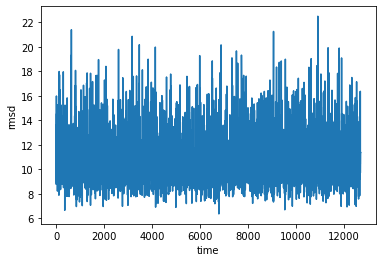

In [3]:
plt.plot(lrmsd[0:-1:100])
plt.xlabel('time')
_=plt.ylabel('rmsd')

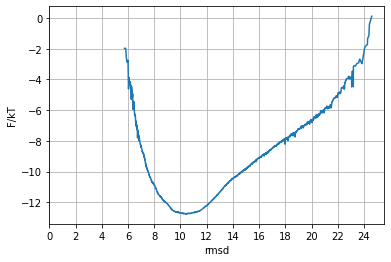

In [4]:
lx,lzh=cfeplib.comp_Zca(lrmsd,a=-1,dx=0.01,dt=1,strict=False)
lf=[-log(zh*2) for zh in lzh]

plt.plot(lx,lf)
plt.xticks(np.arange(0, 25, step=2))
plt.grid()
plt.xlabel('rmsd')
_=plt.ylabel('F/kT')


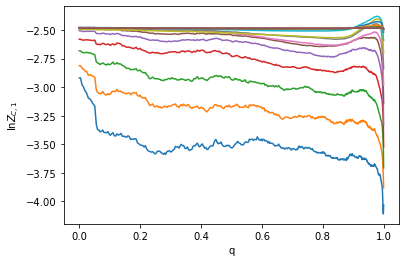

In [6]:
lq=cfeplib.to_committor(lrmsd,0.01,4,11)

ldt=[2**i for i in range(16)]
dx=0.001
for dt in ldt:
    ekn=cfeplib.comp_ekn_tp(lq,x0=0,x1=1,dx=dx,dt=dt)
    lx,lzc1=cfeplib.comp_Zca_ekn(ekn,a=1)
    plt.plot(lx,-np.log(lzc1))
plt.xlabel('q')
_=plt.ylabel('$\ln Z_{C,1}$')

In [8]:
def Nab_traj(lrmsd,a,b):
    il=None
    n=0
    for x in lrmsd:
        ic=None
        if x<a: ic=1
        if x>b: ic=2
        if ic!=None and il!=None and ic!=il: n+=1
        if ic!=None: il=ic
    return n/2.
        
def Nab_model(lx,lzc1,a,b):
    lx1=[lx[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    ly1=[1/lzc1[i] for i in range(len(lx)) if a<lx[i] and lx[i]<b]
    
    from scipy.integrate import simps
    I=simps(ly1,lx1)
    return 1./I

a=4
b=11
lx1,ly1=cfeplib.comp_Zca(lrmsd,a=1,dx=0.0001)
print (Nab_traj(lrmsd,a,b),Nab_model(lx1,ly1,a,b))

12.0 39.913035209887894


In [9]:
for dt in range(1,11):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

1 12.0 39.91303519097151
2 12.0 29.05061909945109
3 10.0 26.371576125898446
4 10.0 23.792174449525415
5 10.0 20.87282781593447
6 9.0 21.824583713915516
7 8.0 20.547343355080276
8 10.0 19.562754489329272
9 8.0 20.093162272612616
10 8.0 19.107438573837737


In [10]:
for dt in range(10,40):
    traj1=[lrmsd[i] for i in range(1,len(lrmsd),dt)]
    lx1,ly1=cfeplib.comp_Zca(traj1,a=1,dx=0.0001)
    print (dt,Nab_traj(traj1,a,b),Nab_model(lx1,ly1,a,b))

10 8.0 19.107438573837737
11 9.0 19.444819892241814
12 9.0 19.7667335220414
13 8.0 18.66101992229416
14 8.0 19.180166168066204
15 7.0 18.058937756600187
16 8.0 17.580527310051565
17 8.0 17.72331284531589
18 8.0 18.893614313867257
19 9.0 18.843225160866062
20 7.0 18.23784863276438
21 8.0 18.52530764908033
22 7.0 16.208676652613786
23 8.0 17.573541961840885
24 7.0 18.802074196556887
25 6.0 15.65547834774152
26 7.0 16.212318719202777
27 8.0 16.24156582545639
28 7.0 16.250014263661058
29 6.0 14.504768111170339
30 7.0 15.758396708655408
31 8.0 16.24654182672706
32 8.0 16.15915581371152
33 8.0 15.715691931146717
34 7.0 15.11849789773679
35 7.0 16.036105568160906
36 8.0 18.228187876480295
37 8.0 16.712143919413258
38 8.0 17.387239259062028
39 4.0 15.044087592325448


In [11]:
def fab_model(lrmsd,a,b,dx=0.001):
    lx,lzc1=cfeplib.comp_Zca(lrmsd,1,dx=dx)
    lx,lzh=cfeplib.comp_Zca(lrmsd,-1,dx=dx)
    from scipy.integrate import cumtrapz,simps
    ly=[1/y for y in lzc1]
    lq=cumtrapz(ly,lx,initial=0)
    lqa=[(abs(x-a),i) for i,x in enumerate(lx)]
    lqa.sort()
    ia=lqa[0][-1]
    qa=lq[ia]
    lqb=[(abs(x-b),i) for i,x in enumerate(lx)]
    lqb.sort()
    ib=lqb[0][-1]
    qb=lq[ib]
    def qp(q,qa,qb):
        if q<qa: return 0
        if q>qb: return 1
        return (q-qa)/(qb-qa)
    lqp=[qp(q,qa,qb) for q in lq]
    lind=[1 if a<x and x<b else 0 for x in lx]
    nab=1/simps([ind/zc1 for ind,zc1 in zip(lind,lzc1)],lx)
    n=len(lrmsd)
    ztot=simps(lzh,lx)
    mfptab=simps([zh*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mfptba=simps([zh*q for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    mtpt=simps([zh*q*(1-q) for zh,q in zip(lzh,lqp)],lx)/ztot*n/nab
    return nab,mfptab,mfptba,mtpt

def fab_traj(lrmsd,a,b):
    il=None
    nab=0
    mfptab=0
    mfptba=0
    mtpt=0
    tp=0
    fp=0
    for i,x in enumerate(lrmsd):
        if x<a: 
            ic=1
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptba=mfptba+i-fp
                fp=i
            il=ic
            tp=i
        if x>b: 
            ic=2
            if il!=None and ic!=il:
                nab=nab+1
                mtpt=mtpt+i-tp
                mfptab=mfptab+i-fp
                fp=i
            il=ic
            tp=i
    return nab/2.,2.*mfptab/nab,2.*mfptba/nab,float(mtpt)/nab
     
print('model: NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_model(lrmsd,a,b))    
print('traj:  NAB=%g, mfpt_AB=%g, mftp_BA=%g, mtpt=%g' %fab_traj(lrmsd,a,b))

model: NAB=39.9222, mfpt_AB=135.722, mftp_BA=31629.6, mtpt=82.3483
traj:  NAB=12, mfpt_AB=462.083, mftp_BA=79065.3, mtpt=280.25
